# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import copy
import numpy as np

import random

import torchvision
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import json
import cv2

import glob
import os

## Set GPU

In [2]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda', index=0)

### Thresholding function to eleminate noise.

In [4]:
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

### Transforms methods for preprocessing images

In [5]:
data_transforms = {
 'train':transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((256,256)),
        transforms.RandomRotation(degrees=(90), fill=255),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=235),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
),
'val': transforms.Compose(
    [
        transforms.Grayscale(3),
        transforms.Resize((256,256)),
        transforms.RandomRotation(degrees=(90), fill=255),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=235),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
}


## Creating Dataset

In [6]:
import os
data_dir = r'C:\Desktop\Project\hand_data_set\MODIFIED_Hands\data_set_v2'
image_datasets_v2 = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders_v2 = {x: torch.utils.data.DataLoader(image_datasets_v2[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes_v2 = {x: len(image_datasets_v2[x]) for x in ['train', 'val']}

class_names = image_datasets_v2['train'].classes

In [44]:
class_names

['hands', 'no_hands']

## Function to plot the training images

Images are blurred to protect confidentiality of clinical data.

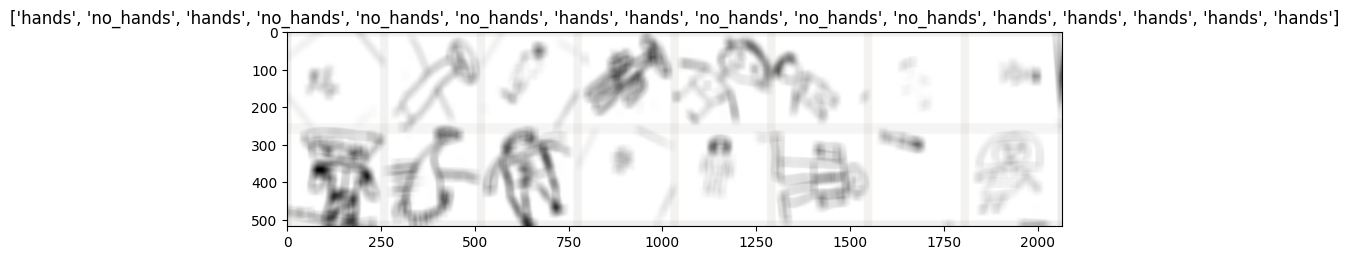

In [7]:
import torchvision
plt.rcParams["figure.figsize"] = (10,4)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders_v2['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
trans = torchvision.transforms.GaussianBlur(kernel_size=(23,29), sigma=(23,23))
# plt.fig
imshow(trans(out), title=[class_names[x] for x in classes])


## Model Building

<p>Using as reference: <a>https://pytorch.org/hub/pytorch_vision_resnet/</a>, <a>https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html</a></p>

In [38]:
import time
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    loss_dict = {"val_loss": [], "train_loss": []}
    acc_dict = {"val_acc": [], "train_acc": []}
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders_v2[phase]:
                

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes_v2[phase]
            epoch_acc = running_corrects.double() / dataset_sizes_v2[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == "val":
                loss_dict['val_loss'].append(float(f'{epoch_loss:.4f}'))
                acc_dict['val_acc'].append(float(f'{epoch_acc:.4f}'))
            if phase == "train":
                loss_dict['train_loss'].append(float(f'{epoch_loss:.4f}'))
                acc_dict['train_acc'].append(float(f'{epoch_acc:.4f}'))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_dict, acc_dict

## Predicting method

In [8]:
def visualize_model_test(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_v2['val']):
                
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                trans = torchvision.transforms.GaussianBlur(kernel_size=(13,13), sigma=(23,23))
                imshow(trans(inputs.cpu().data[j]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Function to save model

In [40]:
def saveModel(model, name: str, path): 
    path = f'{path}/{name}.pth' 
    torch.save(model, path) 

## Function to plot the performance of each model.

In [41]:
def plot_(arr1, arr2, label, xvalues, modelName):
    plt.plot(xvalues, arr1, label = f"training")
    plt.plot(xvalues, arr2, label = f"validation")
    # naming the x axis
    plt.ylabel(label.lower())
    # naming the y axis
    plt.xlabel('epoch')
    # giving a title to my graph
    plt.title(f'Fine-tuned {modelName} {label.title()}')
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

The following code will consist of fine-tuning each model. ResNet50, ResNet101 were trained on local machine. 

VGG16 and ResNet152 were trained on Google Colab.

Every model's history is stores at .txt file.

### ResNet101

In [21]:
torch.cuda.empty_cache()

In [15]:
from torch.optim import lr_scheduler
model_ft_resnet101 = models.resnet101(pretrained=True)
num_ftrs = model_ft_resnet101.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)). 
model_ft_resnet101.fc = nn.Linear(num_ftrs, 2)
# model_ft_resnet101
model_ft_resnet101 = model_ft_resnet101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_resnet101.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\linda\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\linda\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train for 15 epoch

In [17]:
model_ft_resnet101_15, loss_values_15epoch_101, accuracy_values_15epoch_101 = train_model(model_ft_resnet101, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6689 Acc: 0.5516
val Loss: 0.6013 Acc: 0.6500

Epoch 1/14
----------
train Loss: 0.5961 Acc: 0.6984
val Loss: 0.6420 Acc: 0.6792

Epoch 2/14
----------
train Loss: 0.5746 Acc: 0.6925
val Loss: 0.5675 Acc: 0.7333

Epoch 3/14
----------
train Loss: 0.5102 Acc: 0.7460
val Loss: 0.6410 Acc: 0.7333

Epoch 4/14
----------
train Loss: 0.4927 Acc: 0.7639
val Loss: 0.5068 Acc: 0.7500

Epoch 5/14
----------
train Loss: 0.4088 Acc: 0.8194
val Loss: 0.4673 Acc: 0.7792

Epoch 6/14
----------
train Loss: 0.3572 Acc: 0.8274
val Loss: 0.6887 Acc: 0.7125

Epoch 7/14
----------
train Loss: 0.3578 Acc: 0.8512
val Loss: 0.6214 Acc: 0.6958

Epoch 8/14
----------
train Loss: 0.3005 Acc: 0.8611
val Loss: 0.5360 Acc: 0.7750

Epoch 9/14
----------
train Loss: 0.2861 Acc: 0.8849
val Loss: 0.5386 Acc: 0.7792

Epoch 10/14
----------
train Loss: 0.2736 Acc: 0.8829
val Loss: 0.5466 Acc: 0.7500

Epoch 11/14
----------
train Loss: 0.2498 Acc: 0.8810
val Loss: 0.5348 Acc: 0.7625

Ep

### Save model

In [71]:
saveModel(model=model_ft_resnet101_15, path=f"C:\\Desktop\\Project\\history\\v3\\ResNet101", name='model_ft_resnet101_15poch')

### Plot the model history

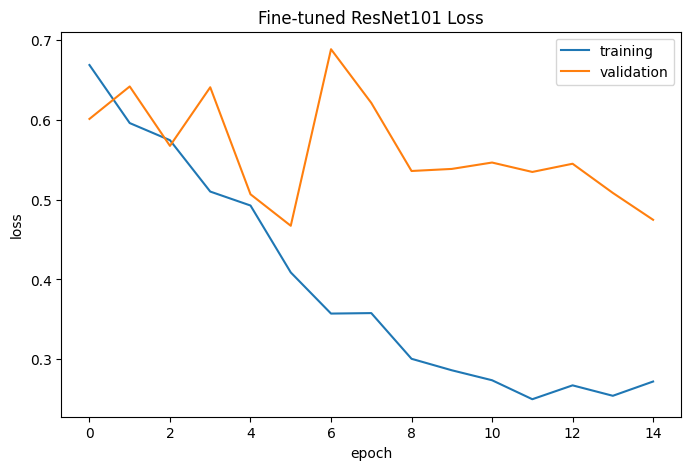

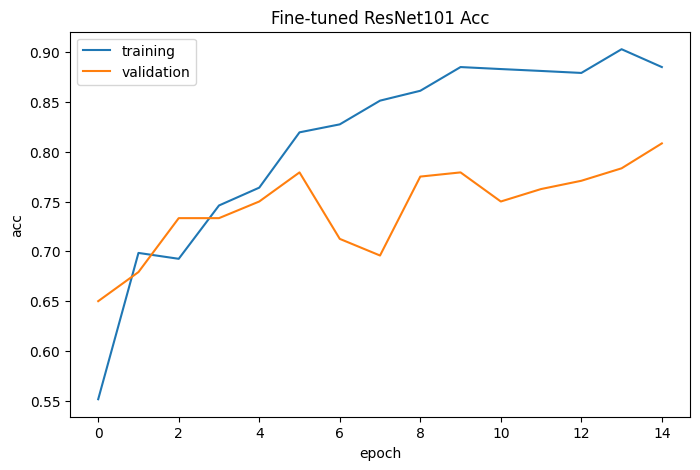

In [74]:
plt.rcParams["figure.figsize"] = (8,5)
# accuracy_values_15epoch_101 = json.loads(accuracy_values_15epoch_101)
# loss_values_15epoch_101 = json.loads(loss_values_15epoch_101)
plot_(arr1=loss_values_15epoch_101['train_loss'], arr2=loss_values_15epoch_101['val_loss'], label='loss', xvalues=list(range(0, 15)), modelName='ResNet101')
plot_(arr1=accuracy_values_15epoch_101['train_acc'], arr2=accuracy_values_15epoch_101['val_acc'], label='acc', xvalues=list(range(0, 15)), modelName='ResNet101')

### Save the history of the model in a .txt file.

In [22]:
accuracy_values_15epoch_101 = json.dumps(accuracy_values_15epoch_101)
loss_values_15epoch_101 = json.dumps(loss_values_15epoch_101)
with open(r'C:\Desktop\Project\history\v3\ResNet101\acc_15e.txt', 'w') as f1:
    f1.write(accuracy_values_15epoch_101)
with open(r'C:\Desktop\Project\history\v3\ResNet101\loss_15e.txt', 'w') as f2:
    f2.write(loss_values_15epoch_101)

### ResNet50

In [24]:
torch.cuda.empty_cache()

In [26]:
from torch.optim import lr_scheduler
model_ft_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_ft_resnet50.fc.in_features
model_ft_resnet50.fc = nn.Linear(num_ftrs, 2)

model_ft_resnet50 = model_ft_resnet50.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_resnet50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [27]:
model_ft_resnet50_20e, loss_values_50_20e, accuracy_values_50_20e = train_model(model_ft_resnet50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.7567 Acc: 0.5307
val Loss: 0.5929 Acc: 0.6875

Epoch 1/19
----------
train Loss: 0.5977 Acc: 0.6752
val Loss: 0.5595 Acc: 0.6917

Epoch 2/19
----------
train Loss: 0.6327 Acc: 0.6594
val Loss: 0.5001 Acc: 0.7333

Epoch 3/19
----------
train Loss: 0.5047 Acc: 0.7545
val Loss: 0.4932 Acc: 0.7708

Epoch 4/19
----------
train Loss: 0.5080 Acc: 0.7307
val Loss: 0.5127 Acc: 0.7292

Epoch 5/19
----------
train Loss: 0.4801 Acc: 0.7960
val Loss: 0.5426 Acc: 0.7292

Epoch 6/19
----------
train Loss: 0.4057 Acc: 0.8356
val Loss: 0.5167 Acc: 0.7708

Epoch 7/19
----------
train Loss: 0.3612 Acc: 0.8436
val Loss: 0.5254 Acc: 0.7458

Epoch 8/19
----------
train Loss: 0.3303 Acc: 0.8614
val Loss: 0.4792 Acc: 0.7667

Epoch 9/19
----------
train Loss: 0.3119 Acc: 0.8495
val Loss: 0.4943 Acc: 0.7833

Epoch 10/19
----------
train Loss: 0.3547 Acc: 0.8495
val Loss: 0.4678 Acc: 0.7750

Epoch 11/19
----------
train Loss: 0.3411 Acc: 0.8515
val Loss: 0.5000 Acc: 0.7583

Ep

In [28]:
saveModel(model=model_ft_resnet50_20e, path=f"C:\\Desktop\\Project\\history\\v3\\ResNet50", name='model_ft_resnet50_20e')

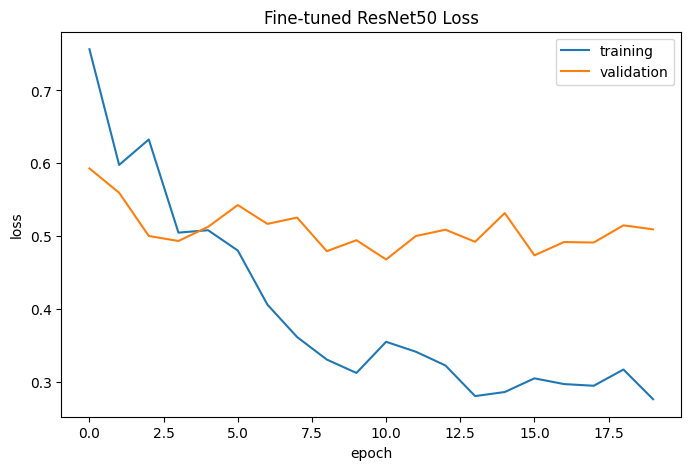

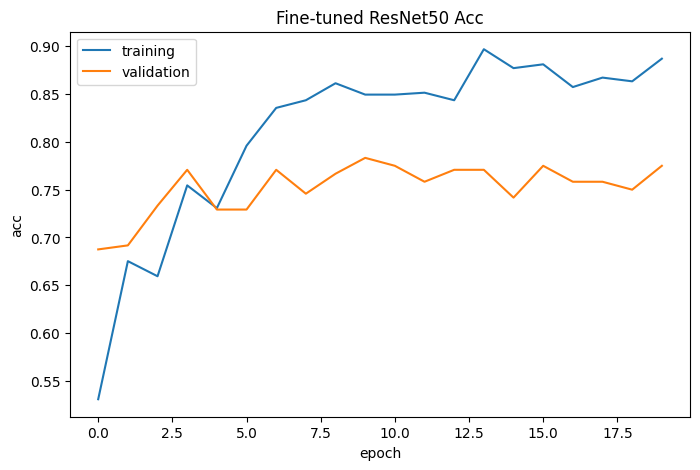

In [38]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=loss_values_50_20e['train_loss'], arr2=loss_values_50_20e['val_loss'], label='loss', xvalues=list(range(0, 20)), modelName='ResNet50')
plot_(arr1=accuracy_values_50_20e['train_acc'], arr2=accuracy_values_50_20e['val_acc'], label='acc', xvalues=list(range(0, 20)), modelName='ResNet50')

In [30]:
accuracy_values_50_20e = json.dumps(accuracy_values_50_20e)
loss_values_50_20e = json.dumps(loss_values_50_20e)
with open(r'C:\Desktop\Project\history\v3\ResNet50\acc_20e.txt', 'w') as f1:
    f1.write(accuracy_values_50_20e)
with open(r'C:\Desktop\Project\history\v3\ResNet50\loss_20e.txt', 'w') as f2:
    f2.write(loss_values_50_20e)

## ResNet152

This was ran on google colab.

In [ ]:
from torch.optim import lr_scheduler
# model.fc.in_features
model_ft_resnet152 = models.resnet152(pretrained=True)
num_ftrs = model_ft_resnet152.fc.in_features

model_ft_resnet152.fc = nn.Linear(num_ftrs, 2)

model_ft_resnet152 = model_ft_resnet152.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_resnet152.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 312MB/s]


In [ ]:
model_ft_resnet152, resnet152_loss_values, resnet152_accuracy_values = train_model(model_ft_resnet152, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6887 Acc: 0.5635
val Loss: 0.6634 Acc: 0.6320

Epoch 1/19
----------
train Loss: 0.6203 Acc: 0.6508
val Loss: 0.5502 Acc: 0.7040

Epoch 2/19
----------
train Loss: 0.5359 Acc: 0.7242
val Loss: 0.5727 Acc: 0.7280

Epoch 3/19
----------
train Loss: 0.5047 Acc: 0.7579
val Loss: 0.4811 Acc: 0.7640

Epoch 4/19
----------
train Loss: 0.4814 Acc: 0.7738
val Loss: 0.6866 Acc: 0.6680

Epoch 5/19
----------
train Loss: 0.4075 Acc: 0.8135
val Loss: 0.4954 Acc: 0.7800

Epoch 6/19
----------
train Loss: 0.3934 Acc: 0.8294
val Loss: 0.5138 Acc: 0.7880

Epoch 7/19
----------
train Loss: 0.3131 Acc: 0.8671
val Loss: 0.5558 Acc: 0.7280

Epoch 8/19
----------
train Loss: 0.2794 Acc: 0.8869
val Loss: 0.5529 Acc: 0.7560

Epoch 9/19
----------
train Loss: 0.2736 Acc: 0.8968
val Loss: 0.5359 Acc: 0.7680

Epoch 10/19
----------
train Loss: 0.2692 Acc: 0.8810
val Loss: 0.5221 Acc: 0.7720

Epoch 11/19
----------
train Loss: 0.2506 Acc: 0.9087
val Loss: 0.5125 Acc: 0.7680

Ep

In [ ]:
saveModel(model=model_ft_resnet152, path=f"/content/drive/MyDrive/Model_ResNet152/final_20e_model", name='model_ft_resnet152')

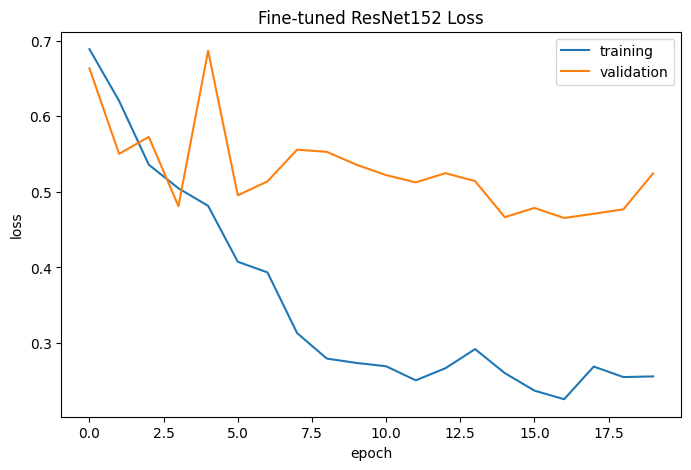

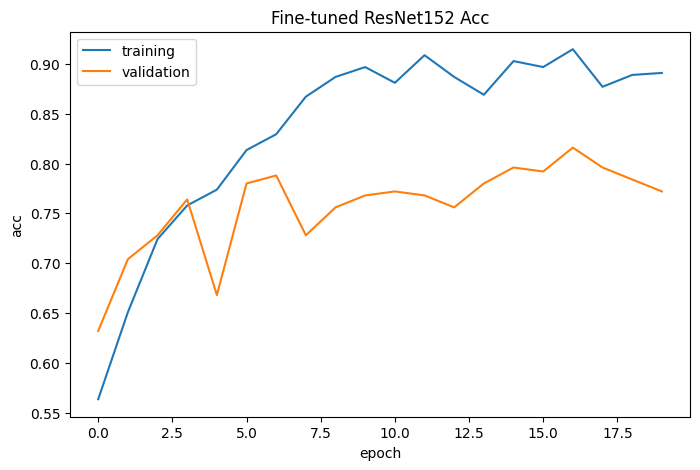

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=resnet152_loss_values['train_loss'], arr2=resnet152_loss_values['val_loss'], label='loss', xvalues=list(range(0, 20)), modelName='ResNet152')
plot_(arr1=resnet152_accuracy_values['train_acc'], arr2=resnet152_accuracy_values['val_acc'], label='acc', xvalues=list(range(0, 20)), modelName='ResNet152')

In [ ]:
resnet152_accuracy_values = json.dumps(resnet152_accuracy_values)
resnet152_loss_values = json.dumps(resnet152_loss_values)
with open('/content/drive/MyDrive/Model_ResNet152/final_20e_model/acc_20e.txt', 'w') as f1:
    f1.write(resnet152_accuracy_values)
with open('/content/drive/MyDrive/Model_ResNet152/final_20e_model/loss_20e.txt', 'w') as f2:
    f2.write(resnet152_loss_values)

# VGG

VGG16 model was run with 10 epochs.

This is the best performing model due to its loss graph having a good fit and 74.4% validation accuracy.

In [ ]:
from torch.optim import lr_scheduler

model_ft_vgg_2 = models.vgg16(pretrained=True)

num_ftrs = model_ft_vgg_2.classifier[0].out_features

model_ft_vgg_2.fc = nn.Linear(num_ftrs, 2)

model_ft_vgg_2 = model_ft_vgg_2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_2= optim.AdamW(model_ft_vgg_2.parameters(),lr=5e-5, weight_decay=0.1)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_2, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft_vgg_, vgg_loss_values_, vgg_accuracy_values_ = train_model(model_ft_vgg_2, criterion, optimizer_ft_2, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.4765 Acc: 0.5476
val Loss: 0.6945 Acc: 0.6040

Epoch 1/9
----------
train Loss: 0.6873 Acc: 0.5952
val Loss: 0.6357 Acc: 0.6320

Epoch 2/9
----------
train Loss: 0.6737 Acc: 0.6270
val Loss: 0.5907 Acc: 0.7120

Epoch 3/9
----------
train Loss: 0.6261 Acc: 0.6766
val Loss: 0.5659 Acc: 0.7200

Epoch 4/9
----------
train Loss: 0.5605 Acc: 0.7202
val Loss: 0.5732 Acc: 0.6880

Epoch 5/9
----------
train Loss: 0.5213 Acc: 0.7619
val Loss: 0.5614 Acc: 0.7520

Epoch 6/9
----------
train Loss: 0.5418 Acc: 0.7421
val Loss: 0.5770 Acc: 0.7200

Epoch 7/9
----------
train Loss: 0.4577 Acc: 0.7996
val Loss: 0.5903 Acc: 0.7080

Epoch 8/9
----------
train Loss: 0.4399 Acc: 0.7897
val Loss: 0.5216 Acc: 0.7480

Epoch 9/9
----------
train Loss: 0.4072 Acc: 0.8254
val Loss: 0.4957 Acc: 0.7440

Training complete in 15m 10s
Best val Acc: 0.752000


In [ ]:
saveModel(model=model_ft_vgg_, path="/content/drive/MyDrive/Model_vgg/v2/10epoch", name='model_ft_vgg_10poch')

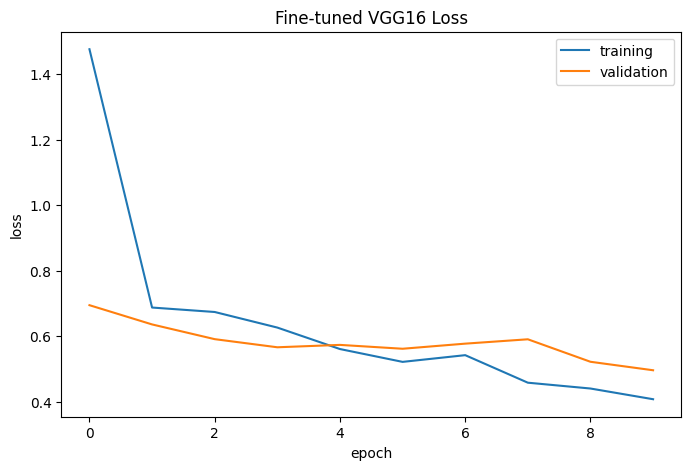

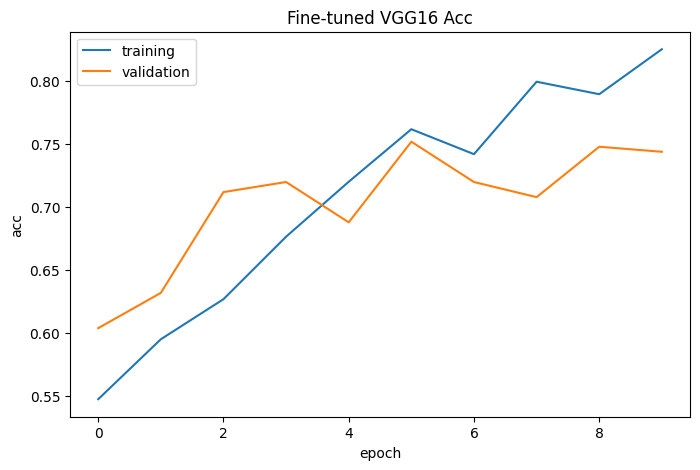

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plot_(arr1=vgg_loss_values_['train_loss'], arr2=vgg_loss_values_['val_loss'], label='loss', xvalues=list(range(0, 10)), modelName='VGG16')
plot_(arr1=vgg_accuracy_values_['train_acc'], arr2=vgg_accuracy_values_['val_acc'], label='acc', xvalues=list(range(0, 10)), modelName='VGG16')

In [ ]:
vgg_accuracy_values_ = json.dumps(vgg_accuracy_values_)
vgg_loss_values_ = json.dumps(vgg_loss_values_)
with open('/content/drive/MyDrive/Model_vgg/v2/10epoch/acc_10e.txt', 'w') as f1:
    f1.write(vgg_accuracy_values_)
with open('/content/drive/MyDrive/Model_vgg/v2/10epoch/loss_10e.txt', 'w') as f2:
    f2.write(vgg_loss_values_)

## Predictions of Tuned Models

The following will be in the order of loading the saved model and then calling "visualize_model_test" method to visualize the predictions of each model.

Images are blurred for confidentiality purposes.

### ResNet50

In [15]:
ResNet50_load = torch.load(r"C:\Desktop\Project\history\v3\ResNet50\model_ft_resnet50_20e.pth")

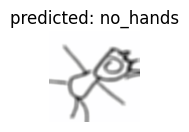

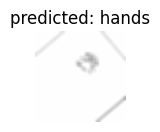

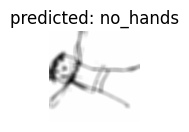

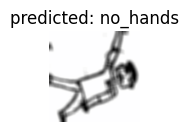

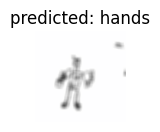

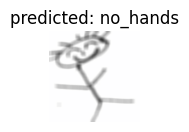

In [16]:
visualize_model_test(ResNet50_load)

### ResNet101

In [13]:
ResNet101_load = torch.load(r"C:\Desktop\Project\history\v3\ResNet101\model_ft_resnet101_15poch.pth")

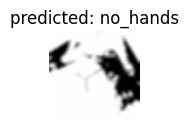

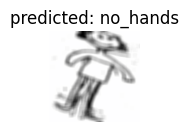

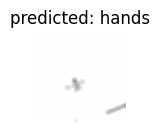

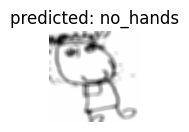

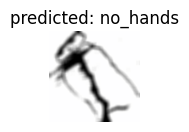

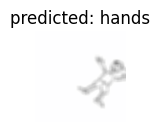

In [14]:
visualize_model_test(ResNet101_load)

## Resnet152

In [11]:
ResNet152_load = torch.load(r"C:\Desktop\Project\history\v3\ResNet152\model_ft_resnet152.pth")

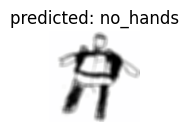

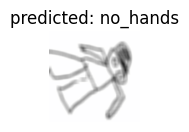

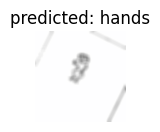

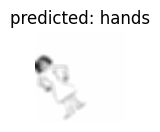

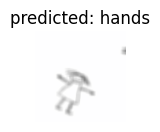

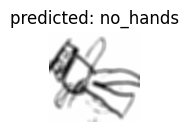

In [12]:
visualize_model_test(ResNet152_load)

## VGG 16

In [9]:
model_vgg_load = torch.load(r"C:\Desktop\Project\history\v3\VGG16\model_ft_vgg_10poch.pth")

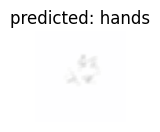

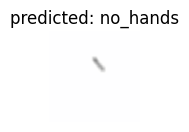

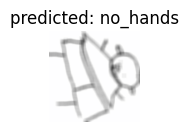

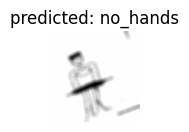

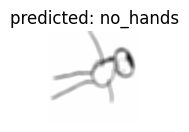

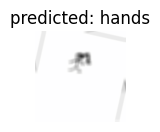

In [10]:
visualize_model_test(model_vgg_load)